In [3]:
# load dataset Iris

from sklearn.datasets import load_iris
import pandas as pd

dataset = load_iris()

df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target

In [4]:
# EDA

print(f'Cek missing values \n{df.isnull().sum()}', '\n')
print(f'\nTotal Missing values: \n{df.isnull().sum().sum()}')


Cek missing values 
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64 


Total Missing values: 
0


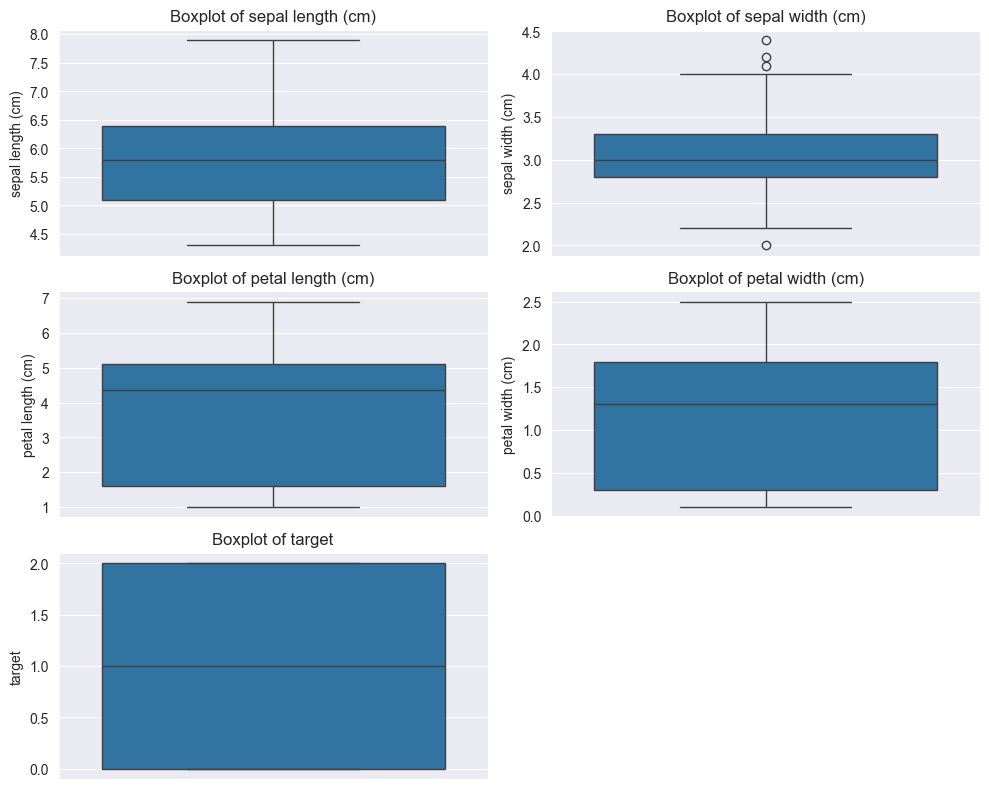

In [6]:
# cek Outlier
import seaborn as sns 
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a boxplot for each feature in the dataframe
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()


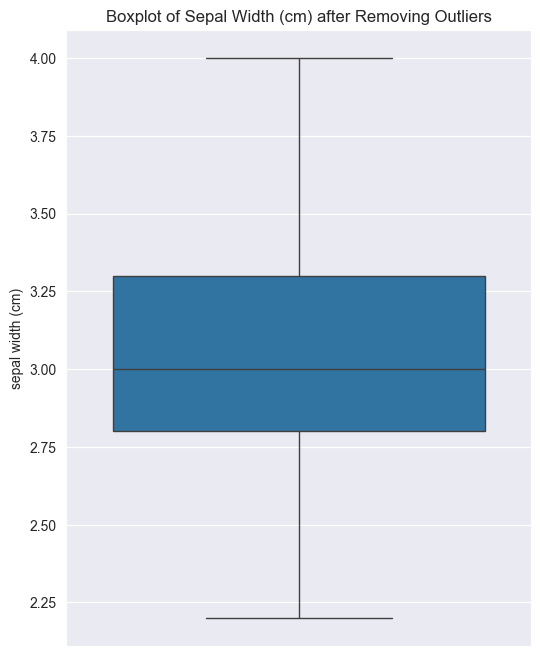

In [7]:
# handle outlier

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi buat handle outlier pake metode IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Batas bawah dan atas
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter data yang di dalam range
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_clean

# Handle outlier di 'sepal width (cm)'
df_outliers_removed = remove_outliers(df, 'sepal width (cm)')

# Plot boxplot setelah outlier dihapus
plt.figure(figsize=(6, 8))
sns.boxplot(y=df_outliers_removed['sepal width (cm)'])
plt.title('Boxplot of Sepal Width (cm) after Removing Outliers')
plt.show()


In [8]:
print(df_outliers_removed.columns)


Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')


In [9]:
# preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# preprocessing
# Split the data into features and target
X = df_outliers_removed.drop(columns=['target'])
y = df_outliers_removed['target']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Select the top 2 features
selector = SelectKBest(score_func=f_classif, k=4)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)



In [10]:
# Training Model

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# modeling
# Initialize CatBoostClassifier
class_weights = {0: 1, 1: 1.5, 2: 1.2}  # Contoh aja, adjust sesuai proporsi data
model = CatBoostClassifier()

# Fit the model
model.fit(X_train_scaled, y_train, early_stopping_rounds=10)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}\n')

from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=0)  # Biar output training nggak rame
scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {scores.mean():.2f} ± {scores.std():.2f}")


Learning rate set to 0.071017
0:	learn: 1.0168144	total: 139ms	remaining: 2m 18s
1:	learn: 0.9475314	total: 141ms	remaining: 1m 10s
2:	learn: 0.8837646	total: 143ms	remaining: 47.4s
3:	learn: 0.8219458	total: 144ms	remaining: 35.9s
4:	learn: 0.7743717	total: 146ms	remaining: 29.1s
5:	learn: 0.7267478	total: 147ms	remaining: 24.4s
6:	learn: 0.6886268	total: 149ms	remaining: 21.2s
7:	learn: 0.6449673	total: 151ms	remaining: 18.7s
8:	learn: 0.6078578	total: 152ms	remaining: 16.8s
9:	learn: 0.5758394	total: 154ms	remaining: 15.2s
10:	learn: 0.5467206	total: 155ms	remaining: 13.9s
11:	learn: 0.5213915	total: 157ms	remaining: 12.9s
12:	learn: 0.4980261	total: 158ms	remaining: 12s
13:	learn: 0.4736122	total: 160ms	remaining: 11.3s
14:	learn: 0.4504179	total: 161ms	remaining: 10.6s
15:	learn: 0.4325925	total: 163ms	remaining: 10s
16:	learn: 0.4133168	total: 165ms	remaining: 9.53s
17:	learn: 0.3969634	total: 166ms	remaining: 9.08s
18:	learn: 0.3801202	total: 168ms	remaining: 8.68s
19:	learn: 0.

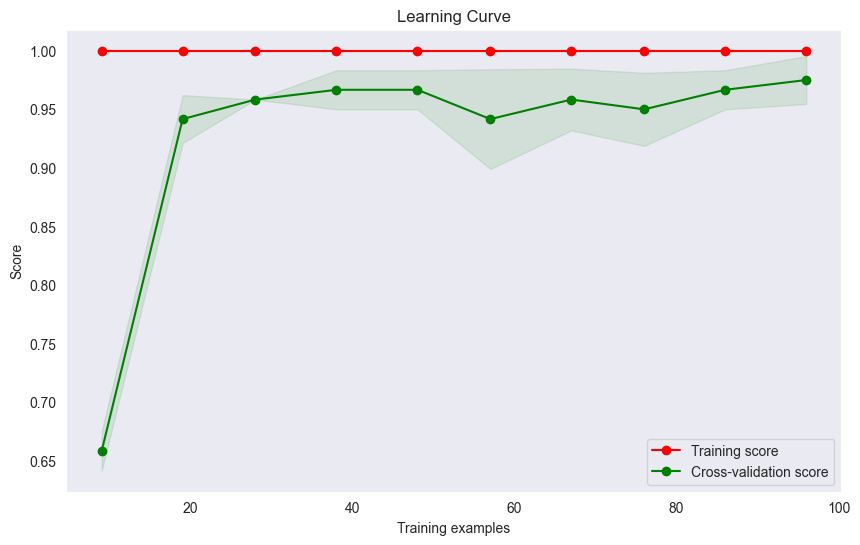

In [11]:
# learning curve berdasarkan training model

from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()

#### depth → Ngatur kedalaman decision tree (default: 6). Kalau terlalu dalam, model jadi terlalu kompleks. Kita coba turunin dulu.
#### learning_rate → Ngatur seberapa besar langkah update model (default: 0.03). Kalau terlalu tinggi, model bisa nggak stabil; kalau terlalu kecil, konvergensinya lambat. Kita coba eksperimen.
#### l2_leaf_reg → Regularisasi L2 buat leaf node biar nggak terlalu fit ke data (default: 3). Kita coba naikin buat nge-rem overfitting.
#### iterations → Jumlah boosting rounds. Bisa coba naikin atau turunin sambil lihat performa.

In [12]:
# Hyperparameter gridsearch

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Inisialisasi model
cat_model = CatBoostClassifier(verbose=0, early_stopping_rounds=10)

# Hyperparameter grid
param_grid = {
    'depth': [1, 2, 3, 4, 5],  # Turunin dari sebelumnya 6-10
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [8, 9, 11, 15],  # Coba naikkan
    'iterations': [40, 45, 50]
}

# GridSearchCV
grid_search = GridSearchCV(cat_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Hasil terbaik
print(f"Best params: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Evaluasi di test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Best params: {'depth': 3, 'iterations': 45, 'l2_leaf_reg': 9, 'learning_rate': 0.03}
Best cross-validation score: 0.975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      0.94         9
           2       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



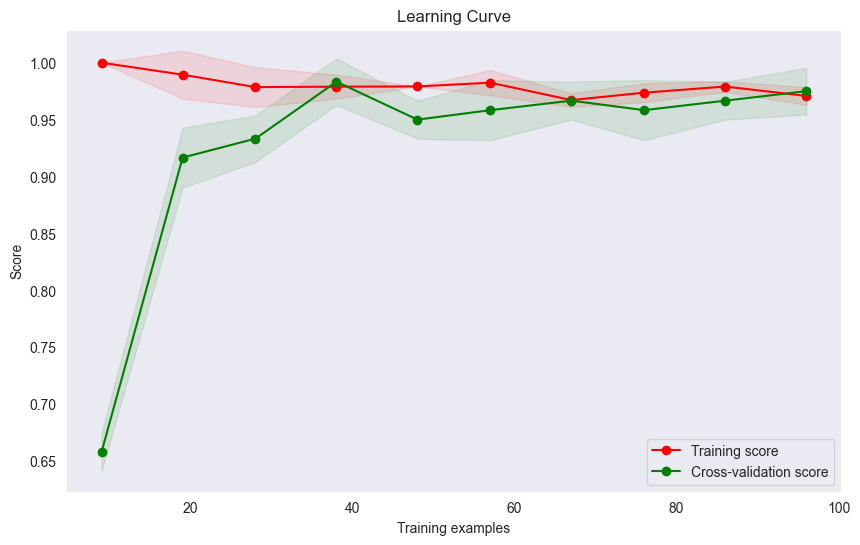

In [13]:
# learning curve berdasarkan GridSearchCV

from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()

#Dari grafik learning curve yang terakhir (dengan learning_rate = 0.03), ini nggak overfitting, Cen. Aku jelasin kenapa:
#Training score (garis merah) dan Cross-validation score (garis hijau) mendekati satu sama lain di titik-titik akhir — artinya model performanya konsisten baik di data training maupun validasi.
#Ada gap kecil di awal, tapi makin banyak data training, gap itu makin menutup. Ini tanda kalau model belajar dengan baik dan nggak "terjebak" di data training aja.
#Cross-validation score cukup stabil dan tetap tinggi, jadi model juga bisa generalisasi dengan baik ke data baru.

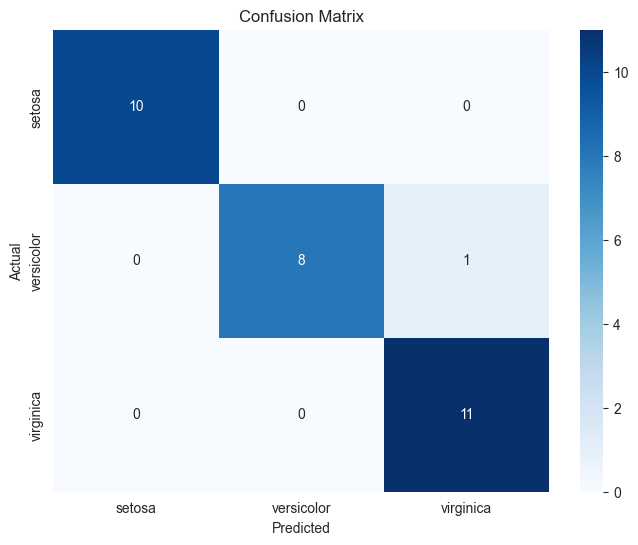

Precision: 0.9694444444444444
Recall: 0.9666666666666667
F1 Score: 0.9664109121909632


In [14]:
# evaluasi total

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.target_names, yticklabels=dataset.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [ ]:
# cross validation

import numpy as np

# Perform 5-fold cross validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Average CV score: {:.3f} (+/- {:.3f})".format(cv_scores.mean(), cv_scores.std() * 2))

Cross-validation scores: [0.96666667 0.96551724 0.93103448 0.89655172 1.        ]
Average CV score: 0.952 (+/- 0.071)
